Using data from the acclaimed US NEWS HEALTH website to uncover some interesting insights on healthcare recommendations.
According to the data, there are 720 cancer-specific hospitals across the nation. With 68 of these hospitals, California leads the way, followed by Texas with 48 and Florida with 48 each. Among the top five are 45 cancer-specialty hospitals in New York, along with 43 in Pennsylvania.

Let's talk quality now. Our analysis of the data revealed that New York, California, and Texas had the top 3 hospitals ranked in the 80th percentile for cancer specialties, with impressive counts of 17, 15, and 13, respectively. In terms of cancer care, these are some of the best.

As for the bottom 10 percent, the top three states with the highest counts were California, Pennsylvania, and Alabama, with a combined count of six.

Not only does this data provide a detailed picture of the distribution of cancer-specialized hospitals, it also reveals the concentration of top-performing institutions in certain states. In our ongoing research, we look forward to exploring more nuances in the healthcare landscape.



In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
cancer_df = pd.read_csv('../data/us_cancer_center_720.csv').iloc[:,1:]
cancer_df.rename(columns = {'Name (Specialty)':'NAME',
                            'AHA ID':'AHA_ID',
                            'Specialty Score':'SCORE',
                            'Specialty Ranking':'RANKING'}, inplace = True)
print(cancer_df.shape)
cancer_df.head()

(720, 8)


,NAME,AHA_ID,ZIP,STATE,SCORE,RANKING,LATITUDE,LONGITUDE
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0/100,1.0,29.707670,-95.397844
1,Mayo Clinic,6610451,53821,WI,79.9/100,3.0,43.051688,-91.132867
2,UCLA Medical Center,6931755,90095,CA,73.2/100,5.0,34.065563,-118.445498
3,Cleveland Clinic,6410670,44333,OH,71.9/100,6.0,41.131162,-81.610786
4,Cedars-Sinai Medical Center,6930444,90048,CA,67.7/100,11.0,34.075160,-118.381094


# Find any missing value

In [9]:
cancer_df.isna().sum()

NAME           0
AHA_ID         0
ZIP            0
STATE          0
SCORE          0
RANKING      692
LATITUDE       0
LONGITUDE      0
dtype: int64

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '16'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '22'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '43'),
 Text(0, 0, '45'),
 Text(0, 0, '48'),
 Text(0, 0, '48'),
 Text(0, 0, '68')]

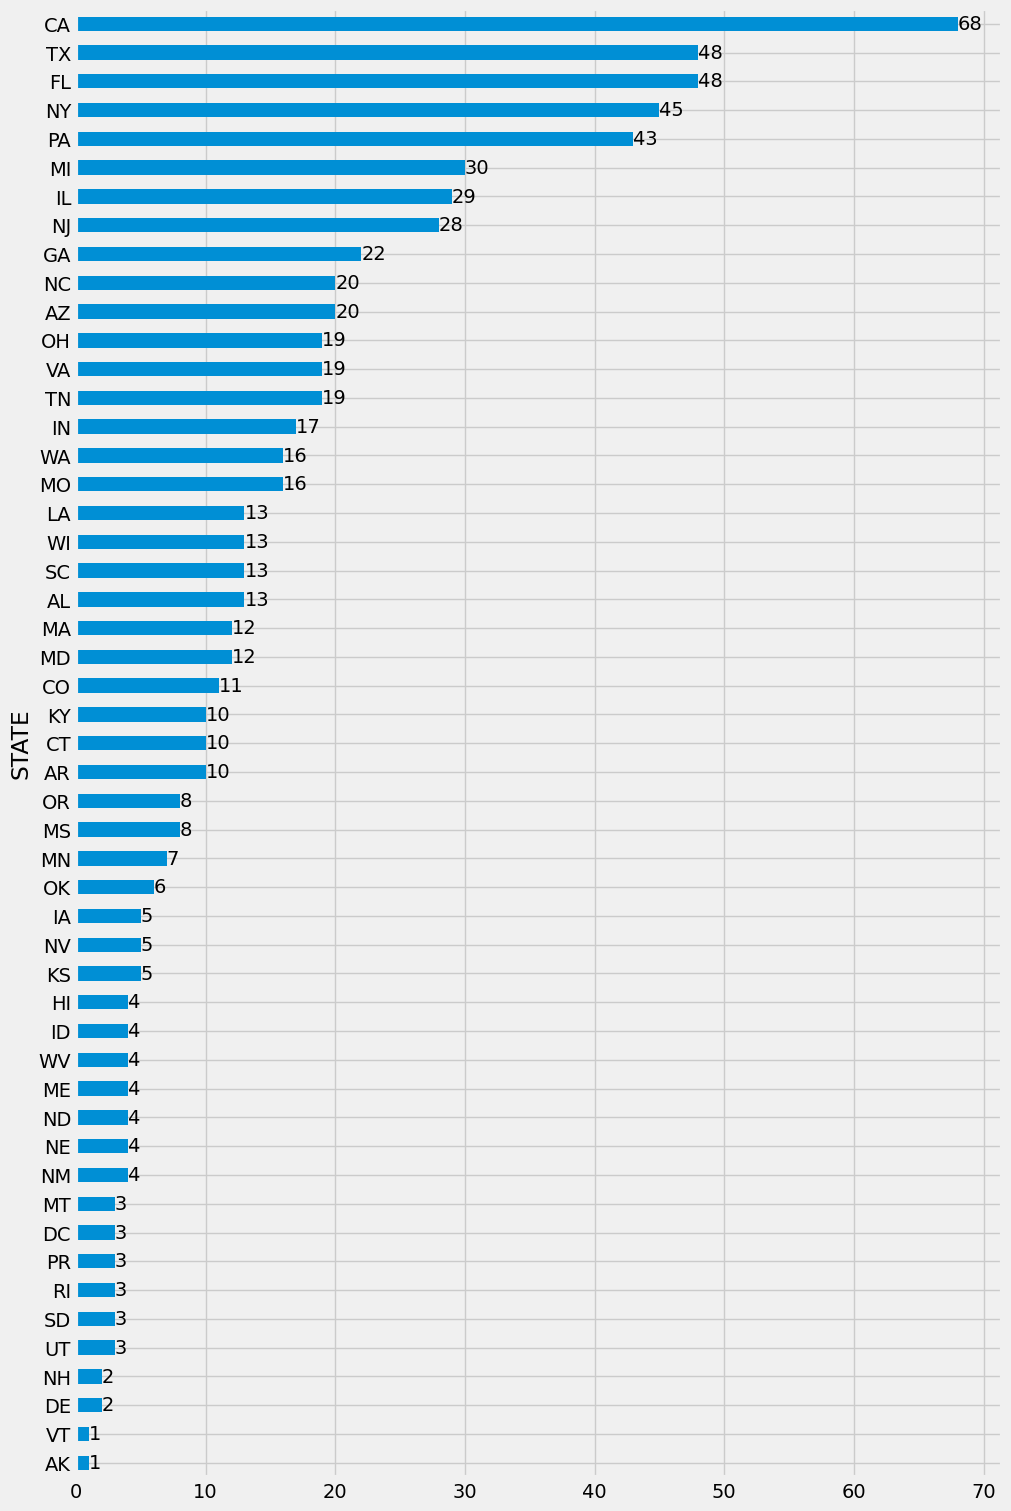

In [15]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df.groupby(['STATE'])['NAME'].size().sort_values().plot.barh()
ax.bar_label(ax.containers[0])

In [32]:
cancer_df['RAW_SCORE'] = cancer_df.SCORE.apply(lambda x: x.split('/')[0])
cancer_df['RAW_SCORE'] = cancer_df['RAW_SCORE'].astype('float64')

In [33]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       720 non-null    object 
 1   AHA_ID     720 non-null    object 
 2   ZIP        720 non-null    object 
 3   STATE      720 non-null    object 
 4   SCORE      720 non-null    object 
 5   RANKING    28 non-null     float64
 6   LATITUDE   720 non-null    float64
 7   LONGITUDE  720 non-null    float64
 8   RAW_SCORE  720 non-null    float64
dtypes: float64(4), object(5)
memory usage: 50.8+ KB


In [36]:
cancer_df.sort_values(by = 'RAW_SCORE', ascending = False)

,NAME,AHA_ID,ZIP,STATE,SCORE,RANKING,LATITUDE,LONGITUDE,RAW_SCORE
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0/100,1.0,29.707670,-95.397844,100.0
671,Memorial Sloan Kettering Cancer Center,6213060,10065-6007,NY,85.7/100,2.0,40.764100,-73.956000,85.7
1,Mayo Clinic,6610451,53821,WI,79.9/100,3.0,43.051688,-91.132867,79.9
2,UCLA Medical Center,6931755,90095,CA,73.2/100,5.0,34.065563,-118.445498,73.2
3,Cleveland Clinic,6410670,44333,OH,71.9/100,6.0,41.131162,-81.610786,71.9
...,...,...,...,...,...,...,...,...,...
662,Mercy Health-West Hospital,6410518,45211,OH,8.3/100,NaN,39.180947,-84.597303,8.3
663,Eastern Idaho Regional Medical Center,6820165,83404,ID,6.5/100,NaN,43.470267,-111.992095,6.5
664,Self Regional Healthcare-Greenwood,6370375,29646,SC,5.5/100,NaN,34.171872,-82.156478,5.5
665,McLaren Greater Lansing Hospital,6440009,48910,MI,4.6/100,NaN,42.701649,-84.501638,4.6


In [37]:
cancer_df['Percentile Rank'] = cancer_df.RAW_SCORE.rank(pct = True) 

# Top 20% high score from NY

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '7'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '15'),
 Text(0, 0, '17')]

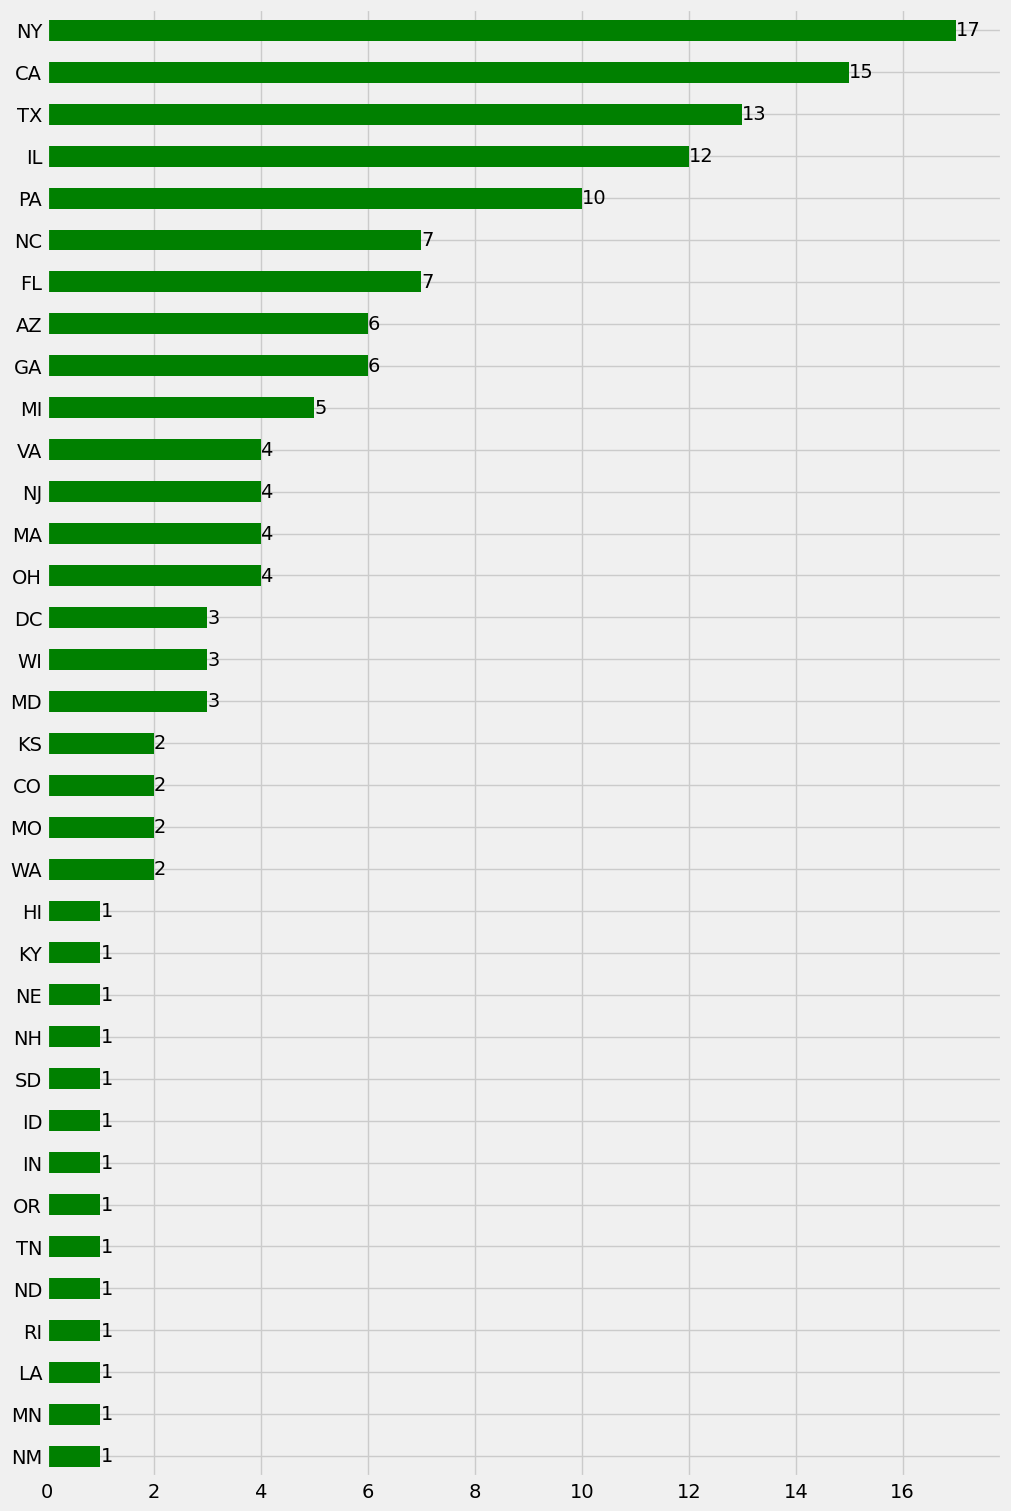

In [55]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df[cancer_df['Percentile Rank'] >= 0.80]['STATE'].value_counts().sort_values(ascending = True).plot.barh(color = 'green')
ax.bar_label(ax.containers[0])


# Bottom 10

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '9')]

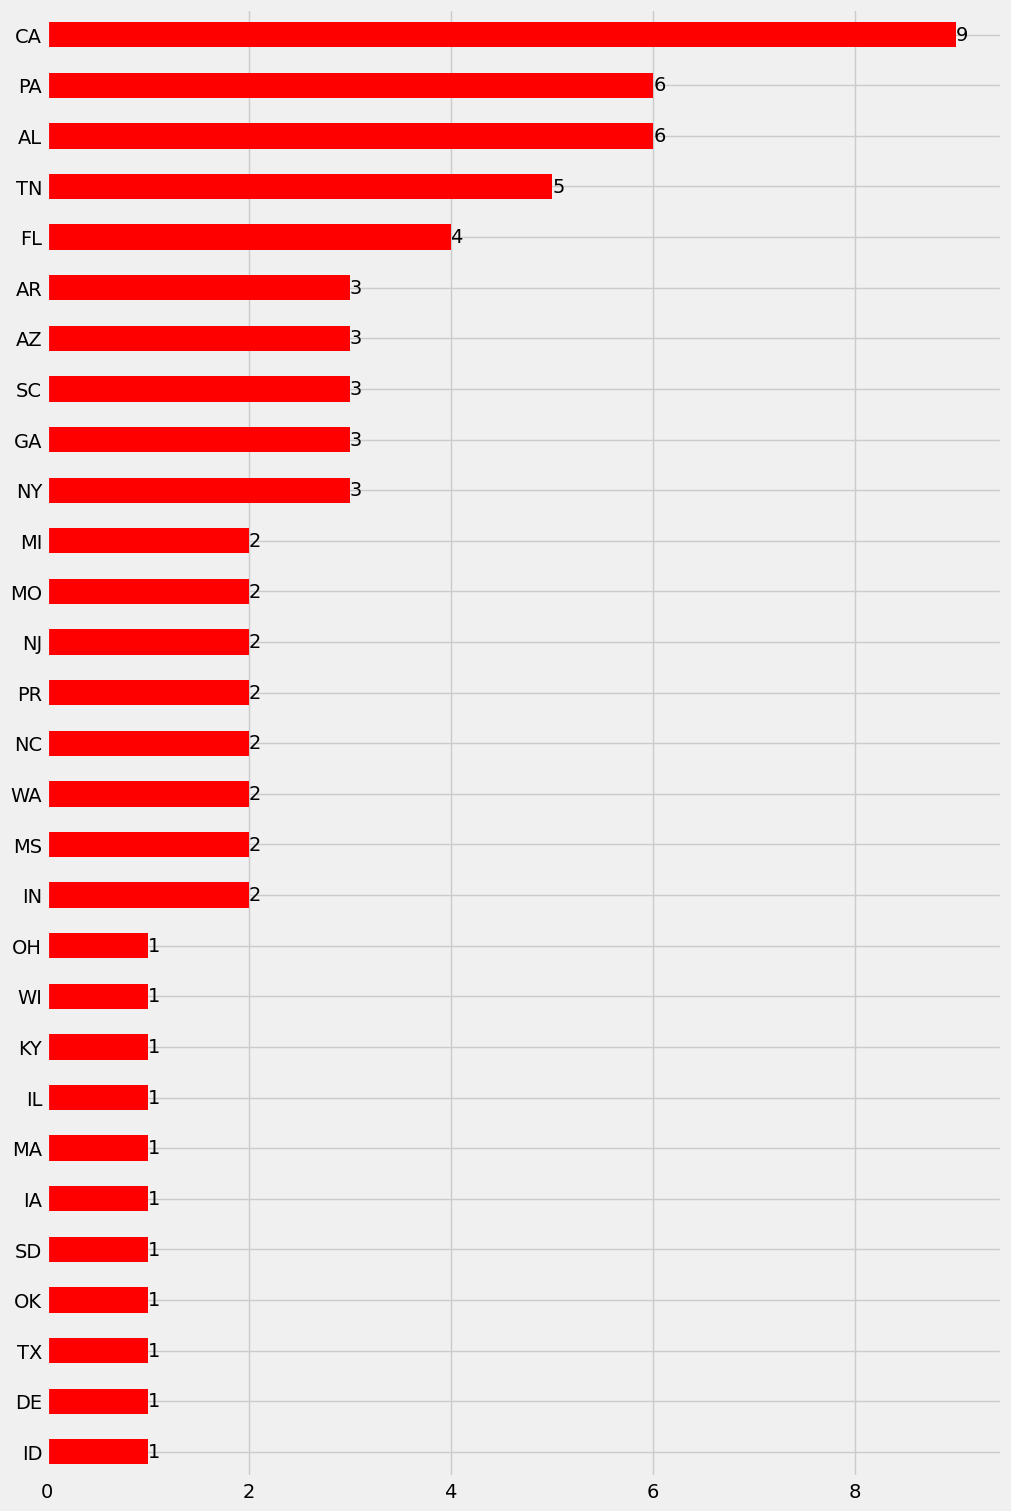

In [48]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df[cancer_df['Percentile Rank'] <= 0.10]['STATE'].value_counts().sort_values(ascending = True).plot.barh(color = 'red')
ax.bar_label(ax.containers[0])